Text(0.5, 1.0, 'Simulation')

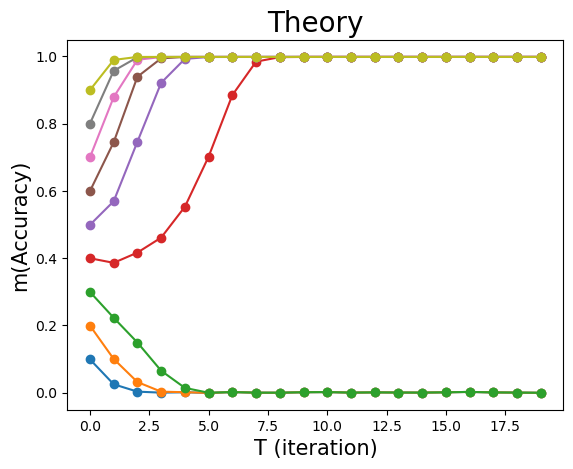

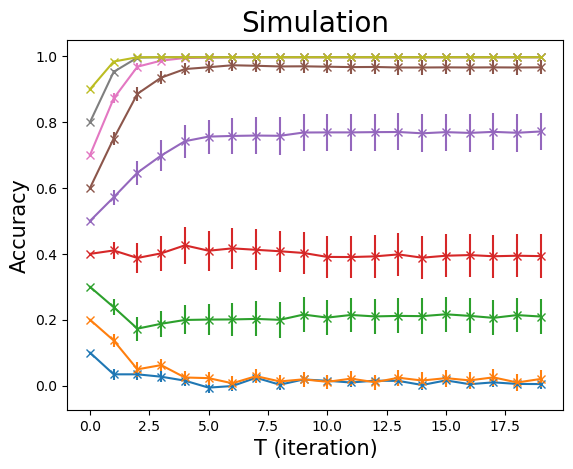

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, pi, exp
from scipy.special import erf

fig, ax = plt.subplots()

T = 20
Nex = 10**6
alpha = 0.05

Nsamp = 1

m0_list = [0.1*n for n in range(1,10)]

rng = np.random.RandomState(seed=1)



#### 理論
for m0 in m0_list:
    m_list_list = []
    rng = np.random.RandomState(seed=2)
    for nsamp in range(Nsamp):
        Q = np.zeros((T+1,T+1)) # x の２時刻相関
        S = np.zeros((T+1,T+1)) # s と ik の２時刻相関

        x = np.zeros((T+1,Nex))
        h = np.zeros((T+1,Nex))
        g1 = rng.standard_normal((T+1,Nex))
        g2 = rng.standard_normal((T+1,))
        phi = np.zeros((T+1,Nex))
        z = np.zeros((T+1,))

        x[0,:] = np.ones((Nex,))
        for i in range(Nex):
            if rng.random() > (1+m0)/2:
                x[0,i] *= (-1)
        phi[0,:] = np.sqrt(alpha/2)*g1[0,:].copy() # Rh[0,0] = alpha/2
        z[0] = np.sqrt(alpha/Nex)*g2[0].copy() # alpha/Nex*Q[0,0] = alpha/Nex
        
        h[0,:] = x[0,:].mean()**2 /2 + phi[0,:].copy() -z[0].copy()*x[0,:] -1/Nex/2- x[0,:].mean()**2/Nex+1/Nex**2
        x[1,:] = np.sign(h[0,:])


        Q[0,0] = 1
        Q[0,1] = (x[0,:]*x[1,:]).mean()
        Q[1,0] = Q[0,1]
        Q[1,1] = 1

        S[0,0] = 0
        S[0,1] = 0
        #S[1,0] = 0       
        S[1,0] = -2/sqrt(alpha*pi)*exp(-(x[0,:].mean())**4/(4*alpha))
        S[1,1] = 0

        m_list = [x[0,:].mean()]
        for t in range(1,T):
            m = x[t,:].mean()
            m_list.append(m)
    
            Rh = alpha/2 * Q[:t+1,:t+1]**2 # ノイズの共分散行列の評価    

            [D,U] = np.linalg.eigh(Rh) # 固有値の桁落ちへの対応
            if min(D) < 1.0e-8: 
                Rh = Rh + (1.0e-8-min(D))*np.eye(t+1)
            L = np.linalg.cholesky(Rh) # 共分散行列をコレスキー分解
            phi[:t+1,:] = L@g1[:t+1,:] # 相関のあるガウス乱数の発生
            Sh = alpha*Q[:t+1,:t+1]*S[:t+1,:t+1].T # 応答関数
            [D2,U2] = np.linalg.eigh(Q[:t+1,:t+1]) # 固有値の桁落ちへの対応
            if min(D2) < 1.0e-8: 
                 Q[:t+1,:t+1] = Q[:t+1,:t+1] + (1.0e-8-min(D2))*np.eye(t+1)
            L2 = np.linalg.cholesky(Q[:t+1,:t+1]) # 共分散行列をコレスキー分解
            z[:t+1] = np.sqrt(alpha/Nex)*L2 @g2[:t+1]

            h[t,:] = x[t,:].mean()**2 /2  + phi[t,:] - (Sh[:,t])@x[:t+1,:] 
            #-alpha/2 * x[t,:] * np.sum(S[t,:t]) 
            #+  x[t,:] * z[t]   # 局所場の評価
            x[t+1,:]= np.sign(h[t,:]) # 次時刻の変数
            Q[:t+2,:t+2] = (x[:t+2,:]@x[:t+2,:].T)/Nex
    
            xphi = (x[t+1,:]*phi[:t+1,:]).mean(axis = 1) # [x phi] の平均
            S[t+1,:t+1] = -np.linalg.inv(Rh)@xphi # [\partial x/\partial \phi] = -[x ik] の評価
    
        m_list_list.append(m_list)

    m_array = np.array(m_list_list)

    
    ax.plot([n for n in range(int(T))], m_array.mean(axis=0), marker = 'o')

ax.set_xlabel('T (iteration)',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)
ax.set_title('Theory',fontsize=20)


    #### 実験    
fig, ax = plt.subplots()

N = 100
M = int(alpha*N**2)

Nsamp =50

cmap = plt.get_cmap('tab10')
#colors = cmap(np.linspace(0, 1, len(x))) 
colors = cmap(np.linspace(0, 1, N))
k = 0

for m0 in m0_list:
    rng = np.random.RandomState(seed=56)
    m_exp_list_list = []
    for nsamp in range(Nsamp):
        
        xi = np.sign(rng.standard_normal((M,N)))
        #xi[0,:] = np.ones((N,))
        
        m_exp_list = [m0]
        s = np.ones((N))
        for i in range(N):
            if rng.random() > (1+m0)/2:
                s[i] *= (-1)
        s = s * xi[0,:]
        h= np.zeros((N,))
        for t in range(1,T):
            overlap = (np.outer(xi@s,np.ones((N,))) -xi*s)/N
            a = xi*s
            for i in range(N):
                h[i] = xi[:,i]@(overlap[:,i]**2-np.ones(M,)/N) / 2
            s = np.sign(h)
            m = s * xi[0,:]
            m_exp_list.append(m.mean())

        m_exp_list_list.append(m_exp_list)

    m_exp_array = np.array(m_exp_list_list)
    np.save('m_exp_array.npy', m_exp_array)
    ax.errorbar([n for n in range(int(T))], np.mean(m_exp_array,axis=0),m_exp_array.std(axis=0)/np.sqrt(Nsamp),marker = 'x')
    

ax.set_xlabel('T (iteration)',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)
ax.set_title('Simulation',fontsize=20)




m0 = 0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
m0 = 0.2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
m0 = 0.30000000000000004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
m0 = 0.4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
m0 = 0.5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
m0 = 0.6000000000000001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
m0 = 0.7000000000000001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2

Text(0, 0.5, 'm')

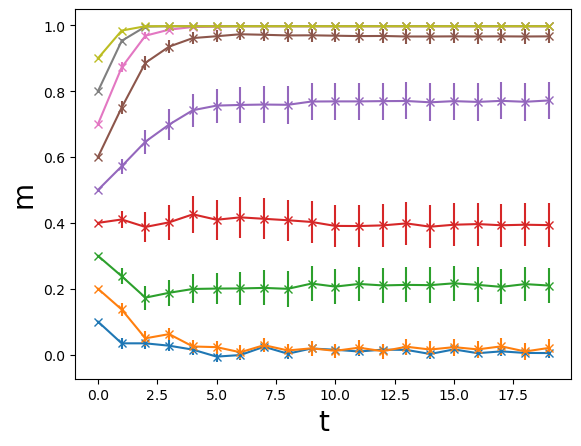

In [10]:
#### 実験    
fig, ax = plt.subplots()

N = 100
M = int(alpha*N**2)

Nsamp =50

cmap = plt.get_cmap('tab10')
#colors = cmap(np.linspace(0, 1, len(x))) 
colors = cmap(np.linspace(0, 1, N))
k = 0

for m0 in m0_list:
    rng = np.random.RandomState(seed=56)
    m_exp_list_list = []
    print('m0 = {}'.format(m0))
    for nsamp in range(Nsamp):
        
        xi = np.sign(rng.standard_normal((M,N)))
        #xi[0,:] = np.ones((N,))
        print(nsamp)
        
    
        m_exp_list = [m0]
        s = np.ones((N))
        for i in range(N):
            if rng.random() > (1+m0)/2:
                s[i] *= (-1)
        s = s * xi[0,:]
        h= np.zeros((N,))
        for t in range(1,T):
            overlap = (np.outer(xi@s,np.ones((N,))) -xi*s)/N
            a = xi*s
            for i in range(N):
                h[i] = xi[:,i]@(overlap[:,i]**2-np.ones(M,)/N) / 2
            s = np.sign(h)
            m = s * xi[0,:]
            m_exp_list.append(m.mean())

        m_exp_list_list.append(m_exp_list)

    m_exp_array = np.array(m_exp_list_list)
    ax.errorbar([n for n in range(int(T))], np.mean(m_exp_array,axis=0),m_exp_array.std(axis=0)/np.sqrt(Nsamp),marker = 'x')
    

ax.set_xlabel('t',fontsize=20)
ax.set_ylabel('m',fontsize=20)
#ax.set_title(f'$\\alpha={alpha}$',fontsize=20)
# fig.savefig(f'3hopfield_dynamics_line_{alpha,Nex,Nsamp}.pdf')

In [9]:
print(-2/sqrt(alpha*pi)*exp(-(x[0,:].mean())**4/(4*alpha)))

-0.19085765984888767
